### Imports

In [1]:
import numpy as np
import scipy.stats as sps
from glob import glob
import pickle
import time
from array import array
from scipy.interpolate import interp1d
import multiprocessing
import matplotlib.pyplot as plt
import uproot as ur
import ROOT as rt
import root_numpy as rtnp
import ROOT.RooFit as rf
from scipy.special import erf
import sys, os
sys.path.append('../lib')
if os.environ['CMSSW_VERSION'] != 'CMSSW_10_2_3':
    raise
from histo_utilities import create_TH1D, create_TH2D, std_color_list, SetMaxToMaxHist, make_ratio_plot
from cebefo_style import Set_2D_colz_graphics
from progressBar import ProgressBar

from analysis_utilities import drawOnCMSCanvas, extarct, extarct_multiple, createSel
from lumi_utilities import getLumiByTrigger

import CMS_lumi, tdrstyle
tdrstyle.setTDRStyle()
CMS_lumi.writeExtraText = 1
CMS_lumi.extraText = "     Internal"

donotdelete = []

Welcome to JupyROOT 6.12/07


In [2]:
rt.gErrorIgnoreLevel = rt.kError
rt.RooMsgService.instance().setGlobalKillBelow(rt.RooFit.ERROR)

In [3]:
import operator
ops = {'>': operator.gt, '<': operator.lt, '=': operator.eq, '==': operator.eq}

In [4]:
m_Jpsi = 3.09691

In [5]:
cl = rt.TLine()
cl.SetLineColor(6)
cl.SetLineStyle(9)
cl.SetLineWidth(2)

In [6]:
colors = [rt.kBlack, rt.kAzure+1, rt.kRed-4, rt.kGreen+1, rt.kViolet-7]

# Load data

In [7]:
dataDir = '../data/cmsRD'
# dsLoc = []
# dsLoc += glob(dataDir + '/ParkingBPH1/Run2018D-05May2019promptD-v1_TagAndProbe_200203_CAND.root')
# treeRD = rt.TChain('TnP/T')
# for l in dsLoc:
#     treeRD.Add(l)
rfRD = rt.TFile(dataDir + '/ParkingBPH1/Run2018D-05May2019promptD-v1_TagAndProbe_200203_CAND.root', 'READ')
treeRD = rfRD.Get('TnP/T')
N_Jpsi = treeRD.GetEntries('abs(massInv - {}) < 0.1'.format(m_Jpsi)) - treeRD.GetEntries('abs(massInv - {}) < 0.1'.format(m_Jpsi - 0.2))
print 'Data Jpsi:', N_Jpsi

Data Jpsi: 5618368


In [8]:
dataDir = '../data/cmsMC_private/BPH_Tag-Probe_B0_JpsiKst-mumuKpi-kp_13TeV-pythia8_Hardbbbar_PTFilter5_0p0-evtgen_SVV_PU20_10-2-3'
dsLoc = glob(dataDir + '/ntuples_TagAndProbe/merged/*.root')
treeMC20 = rt.TChain('TnP/T')
for l in dsLoc:
    treeMC20.Add(l)
N_Jpsi = treeMC20.GetEntries('abs(massInv - {}) < 0.1'.format(m_Jpsi)) - treeMC20.GetEntries('abs(massInv - {}) < 0.1'.format(m_Jpsi - 0.2))
print 'MC20 Jpsi:', N_Jpsi

MC20 Jpsi: 2372102


Explore kinematic distribution to choose a binning

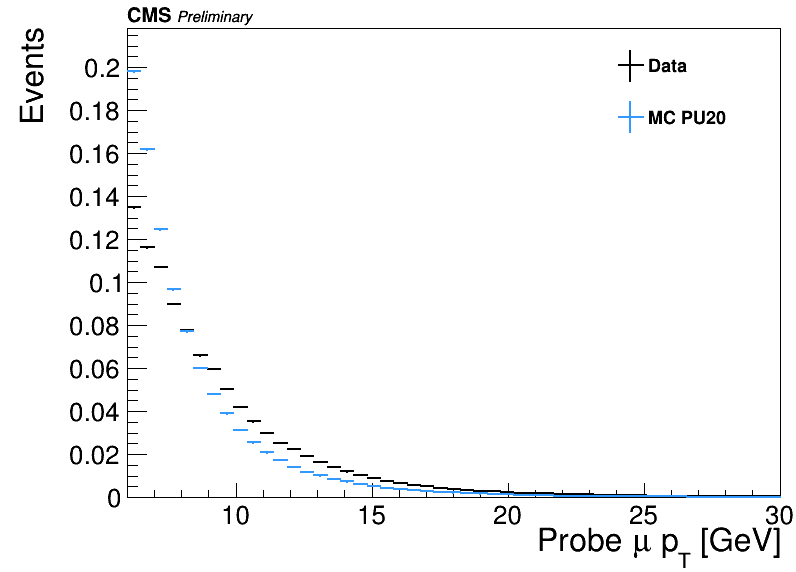

In [9]:
h_list = []
h = create_TH1D(np.zeros(0), name='h',
                title='Data',
                axis_title=['Probe #mu p_{T} [GeV]', 'Events'],
                binning=np.linspace(start=6, stop=30, num=50)
               )
treeRD.Project('h', 'mProbe_pt')
h_list.append(h)

h = create_TH1D(np.zeros(0), name='h2', title='MC PU20', binning=h_list[0].binning)
treeMC20.Project('h2', 'mProbe_pt')
h_list.append(h)

leg = rt.TLegend(0.77, 0.75, 0.95, 0.93)
leg.SetBorderSize(0)
for i, h in enumerate(h_list):
    h.SetLineColor(colors[i])
    h.SetMarkerColor(colors[i])
    h.Sumw2()
    h.Scale(1./h.Integral())
    leg.AddEntry(h, h.GetTitle(), 'lep')
m = SetMaxToMaxHist(h_list)
h_list[0].SetTitle('')

c = drawOnCMSCanvas(CMS_lumi, h_list, 'same')
leg.Draw()
c.Draw()
# c.SetLogy()
# c.SetLogx()

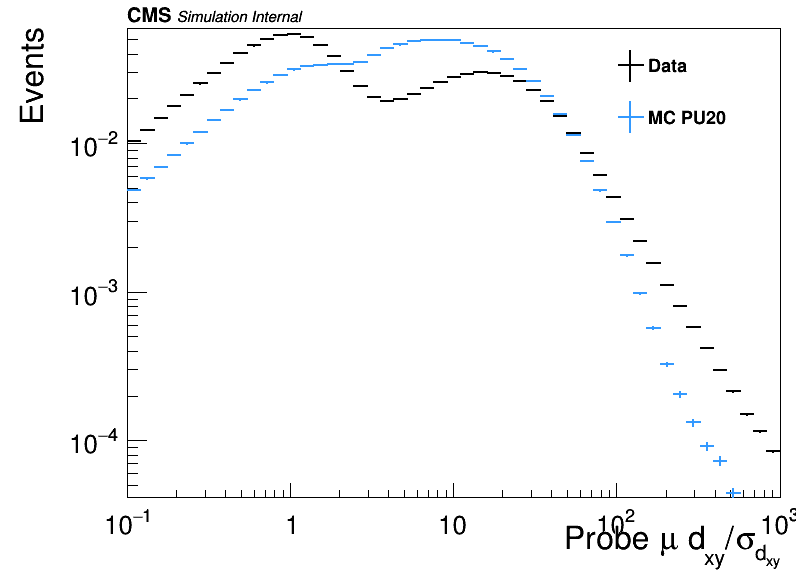

In [22]:
h_list = []
h = create_TH1D(np.zeros(0), name='h',
                title='Data',
                axis_title=['Probe #mu d_{xy}/#sigma_{d_{xy}}', 'Events'],
                binning=np.logspace(start=-1, stop=3, num=50)
               )
treeRD.Project('h', 'mProbe_sigdxy')
h_list.append(h)

h = create_TH1D(np.zeros(0), name='h2', title='MC PU20', binning=h_list[0].binning)
treeMC20.Project('h2', 'mProbe_sigdxy')
h_list.append(h)

leg = rt.TLegend(0.77, 0.75, 0.95, 0.93)
leg.SetBorderSize(0)
for i, h in enumerate(h_list):
    h.SetLineColor(colors[i])
    h.SetMarkerColor(colors[i])
    h.Sumw2()
    h.Scale(1./h.Integral())
    leg.AddEntry(h, h.GetTitle(), 'lep')
m = SetMaxToMaxHist(h_list)
h_list[0].SetTitle('')

c = drawOnCMSCanvas(CMS_lumi, h_list, 'same')
leg.Draw()
c.Draw()
c.SetLogy()
c.SetLogx()

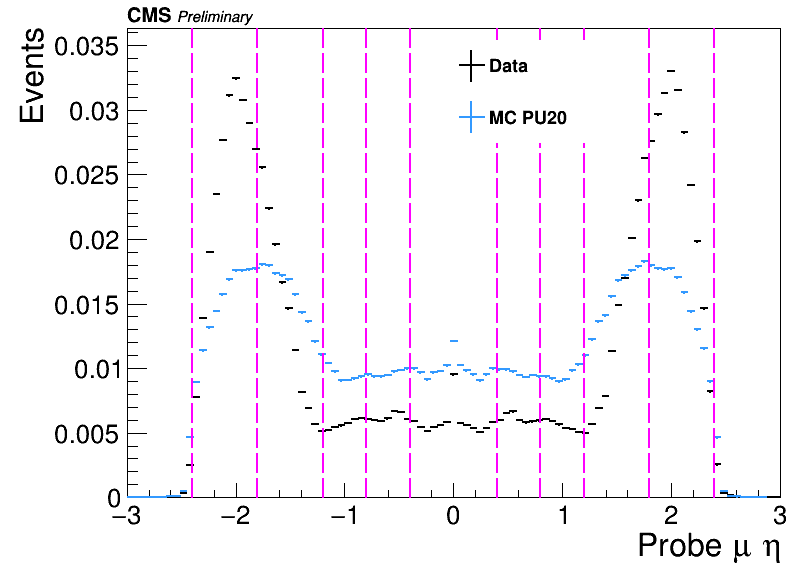

In [10]:
h_list = []
h = create_TH1D(np.zeros(0), name='h',
                title='Data',
                axis_title=['Probe #mu #eta', 'Events'],
                binning=np.linspace(start=-3, stop=3, num=100)
               )
treeRD.Project('h', 'mProbe_eta')
h_list.append(h)

h = create_TH1D(np.zeros(0), name='h2', title='MC PU20', binning=h_list[0].binning)
treeMC20.Project('h2', 'mProbe_eta')
h_list.append(h)

leg = rt.TLegend(0.57, 0.75, 0.75, 0.93)
leg.SetBorderSize(0)
for i, h in enumerate(h_list):
    h.SetLineColor(colors[i])
    h.SetMarkerColor(colors[i])
    h.Sumw2()
    h.Scale(1./h.Integral())
    leg.AddEntry(h, h.GetTitle(), 'lep')
m = SetMaxToMaxHist(h_list)
h_list[0].SetTitle('')

c = drawOnCMSCanvas(CMS_lumi, h_list, 'same')
for e in [0.4, 0.8, 1.2, 1.8, 2.4]:
    cl.DrawLine(e, 0, e, m)
    cl.DrawLine(-e, 0, -e, m)
leg.Draw()
c.Draw()

# Efficiency functions

In [11]:
def fitJpsi(T, psCut, probeVar, mJpsiWindow=0.25, mBins=100, rightText=None):
    h = create_TH1D(np.zeros(0), name='h',
                    title='',
                    axis_title=['mass(#mu#mu) [GeV]', 'Events'],
                    binning=[mBins, m_Jpsi-mJpsiWindow, m_Jpsi+mJpsiWindow]
                   )
    T.Project('h', 'massInv', psCut + ' && fabs(massInv - {}) < {}'.format(m_Jpsi, mJpsiWindow))
    if h.GetMinimum == 0:
        print 'Trying reduce the number of bins'
        mBins = int(mBins*0.5)
        h = create_TH1D(np.zeros(0), name='h',
                    title='',
                    axis_title=['mass(#mu#mu) [GeV]', 'Events'],
                    binning=[mBins, m_Jpsi-mJpsiWindow, m_Jpsi+mJpsiWindow]
                   )
        T.Project('h', 'massInv', psCut + ' && fabs(massInv - {}) < {}'.format(m_Jpsi, mJpsiWindow))
    h.Sumw2()
    N_tot = h.Integral()

    mass = rt.RooRealVar('massInv', 'Mass(#mu#mu)', m_Jpsi-mJpsiWindow, m_Jpsi+mJpsiWindow, 'GeV')
    muPt = rt.RooRealVar('mProbe_pt', '#mu p_{T}', 0, 1e4, 'GeV')
    muEta = rt.RooRealVar('mProbe_eta', '#mu #eta', -5, 5)
    muTrg = rt.RooRealVar(probeVar, 'probe', -1, 2)

    mean = rt.RooRealVar('mean', '#mu', m_Jpsi, m_Jpsi-0.01, m_Jpsi+0.01, 'GeV')
    sigmaN = rt.RooRealVar('sigmaN', '#sigma_{N}', 0.02, 0.01, 0.09, 'GeV') 
    sigmaW = rt.RooRealVar('sigmaW', '#sigma_{W}', 0.06, 0.01, 0.09, 'GeV') 
    gausN = rt.RooGaussian('gausN','gausN', mass, mean, sigmaN)
    gausW = rt.RooGaussian('gausW','gausW', mass, mean, sigmaW)
    fN = rt.RooRealVar('fN', 'f_{N}', 0.5, 0.0, 1.0)
    pdf_sig = rt.RooAddPdf('dGaus', 'sig pdf', rt.RooArgList(gausN, gausW), rt.RooArgList(fN))
    nsig = rt.RooRealVar('nsig', 'N_{S}', 0.9*N_tot, 0, 10*N_tot)
    pdf_sig_ext = rt.RooExtendPdf('esig', 'esig', pdf_sig, nsig)

    lam = rt.RooRealVar('lam', '#lambda', -5, -100, -0.1, 'GeV^{-1}')
    pdf_bkg = rt.RooExponential('expo', 'bkg pdf', mass, lam)
    nbkg = rt.RooRealVar('nbkg', 'N_{B}', 0.1*N_tot, 0, 10*N_tot)
    pdf_bkg_ext = rt.RooExtendPdf('ebkg', 'ebkg', pdf_bkg, nbkg)

    pdf_tot = rt.RooAddPdf('pdftot', 'pdftot', rt.RooArgList(pdf_sig_ext, pdf_bkg_ext))
    
    unbinnedUsed = False
    if h.GetMinimum() == 0 or h.Integral < 2*h.binning[0]:
        print 'Using unbinned likelihood ({:.0f} events)'.format(h.Integral())
        data = rt.RooDataSet('d', 'data', T, rt.RooArgSet(mass, muPt, muEta, muTrg), psCut)
        unbinnedUsed = True
    else:
        data = rt.RooDataHist('d', 'data', rt.RooArgList(mass), h)
        print 'Using binned likeihood'
    
    fr = pdf_tot.fitTo(data, rf.PrintLevel(-1), rf.Save())
    
    frame = mass.frame(rf.Title(""), rf.Bins(h.binning[0]))
    dataPlot = data.plotOn(frame, rf.MarkerStyle(1), rf.DrawOption('E1'), 
                           rf.MarkerColor(1), rf.LineColor(1), rf.MarkerStyle(15))
    
    pdf_tot.plotOn(frame, rf.LineColor(rt.kBlack), rf.LineWidth(1))

    dof = fr.floatParsFinal().getSize()
    chi2 = frame.chiSquare(dof)*dof
    pval = rt.ROOT.Math.chisquared_cdf_c(chi2, dof)
#     print 'chi2: {:.1f}/{:.0f} {:.3f}'.format(chi2, dof, pval)

    pdf_tot.plotOn(frame, rf.Components('ebkg'), rf.LineColor(rt.kRed), rf.LineWidth(2), rf.LineStyle(7))
    pdf_tot.plotOn(frame, rf.Components('esig'), rf.LineColor(rt.kBlue), rf.LineWidth(2), rf.LineStyle(7))

    x_min = mass.getMin() + (mass.getMax()-mass.getMin())*0.04
    x_max = mass.getMin() + (mass.getMax()-mass.getMin())*0.36
    pTxt = rt.TPaveText(x_min, 0.25*dataPlot.GetMaximum(), x_max, 0.9*dataPlot.GetMaximum())
    pTxt.SetBorderSize(0)
    pTxt.SetFillStyle(0)
    pTxt.SetTextAlign(11)
    pTxt.AddText('#chi^{{2}}: {:.1f}/{:.0f} ({:.2f})'.format(chi2, dof, pval))
    pTxt.AddText('N_{{sig}} = {:.0f} +/- {:.0f}'.format(nsig.getVal(), nsig.getError()))

    pTxt.AddText('#mu = {:.1f} +/- {:.1f} MeV'.format(1e3*mean.getVal(), 1e3*mean.getError()))
    pTxt.AddText('#sigma_{{N}} = {:.1f} +/- {:.1f} MeV'.format(1e3*sigmaN.getVal(), 1e3*sigmaN.getError()))
    pTxt.AddText('#sigma_{{W}} = {:.1f} +/- {:.1f} MeV'.format(1e3*sigmaW.getVal(), 1e3*sigmaW.getError()))
    pTxt.AddText('f_{{N}} = {:.2f} +/- {:.2f}'.format(fN.getVal(), fN.getError()))
    frame.addObject(pTxt)
    
    if not rightText is None:
        x_min = mass.getMin() + (mass.getMax()-mass.getMin())*0.65
        x_max = mass.getMin() + (mass.getMax()-mass.getMin())*0.95
        pTxtR = rt.TPaveText(x_min, 0.5*dataPlot.GetMaximum(), x_max, 0.7*dataPlot.GetMaximum())
        pTxtR.SetBorderSize(0)
        pTxtR.SetFillStyle(0)
        for s in rightText:
            pTxtR.AddText(s)
        frame.addObject(pTxtR)
    
    return frame, [nsig.getVal(), nsig.getError()], [chi2, dof, pval]

In [12]:
def analyzeBin(idx, reloadTree=True):
    if reloadTree:
        if len(dataset_loc) == 1:
            fileTmp = rt.TFile(dataset_loc[0], 'READ')
            T = fileTmp.Get('TnP/T')
        else:
            raise
    psCut = []
    lim = {}
    psStrings = []
    for n, i in idx.iteritems():
        lim[n] = [binning[n][i], binning[n][i+1]]
        psCut.append('fabs(fabs(mProbe_{}) - {}) < {}'.format(n, np.mean(lim[n]), 0.5*(lim[n][1]-lim[n][0])))
        psS = '{:.1f} < '.format(lim[n][0])
        if n == 'eta':
            psS += '|#eta|'
        elif n == 'pt':
            psS += 'p_{T}/GeV'
        psS += ' < {:.1f}'.format(lim[n][1])
        psStrings.append(psS)
    psCut = ' && '.join(psCut)

    rt.TGaxis.SetMaxDigits(3)

#     print ' --- Total ---'
    st = time.time()
    frameTot, nSigTot, pValTot = fitJpsi(T, psCut, probeVar,
                                   rightText=['All '] + psStrings
                                  )
#     print 'Time: {:.1f} s'.format(time.time()-st)
    hNtot.SetBinContent(idx['pt']+1, idx['eta']+1, nSigTot[0])
    hNtot.SetBinError(hNtot.GetBin(idx['pt']+1, idx['eta']+1), nSigTot[1])
    hChi2tot.SetBinContent(idx['pt']+1, idx['eta']+1, pValTot[0])
    hChi2tot.SetBinError(hChi2tot.GetBin(idx['pt']+1, idx['eta']+1), pValTot[1])
#     print ' --- Passed ---'
    st = time.time()
    framePassed, nSigPass, pValPass = fitJpsi(T, psCut + ' && ' + probeVar + ' == 1', probeVar,
                                      rightText=['Passed '+trigger] + psStrings
                                     )
#     print 'Time: {:.1f} s'.format(time.time()-st)
    hNpass.SetBinContent(idx['pt']+1, idx['eta']+1, nSigPass[0])
    hNpass.SetBinError(hNpass.GetBin(idx['pt']+1, idx['eta']+1), nSigPass[1])
    hChi2pass.SetBinContent(idx['pt']+1, idx['eta']+1, pValPass[0])
    hChi2pass.SetBinError(hChi2pass.GetBin(idx['pt']+1, idx['eta']+1), pValPass[1])
    
    cTag = '_{}_{}'.format(idx['eta'], idx['pt'])
    c = rt.TCanvas('c'+cTag, 'c'+cTag, 50, 50, 1200, 600)
    c.SetTickx(0)
    c.SetTicky(0)
    c.Divide(2)

    p = c.cd(1)
    frameTot.Draw()
    CMS_lumi.CMS_lumi(p, -1, 33)
    p = c.cd(2)
    framePassed.Draw()
    CMS_lumi.CMS_lumi(p, -1, 33)
    
    imgLoc = '../data/calibration/triggerScaleFactors/figFit'+dataset+'/{}'.format(trigger)
    if not os.path.isdir(imgLoc):
        os.makedirs(imgLoc)
        print 'Creating', imgLoc
    c.SaveAs(imgLoc + '/eta{}_pt{}.png'.format(idx['eta'], idx['pt']))
    return c, idx, nSigTot, pValTot, nSigPass, pValPass

# Run the fit in each bin

In [13]:
dataset = 'MC'
if dataset == 'RD':
    CMS_lumi.extraText = "     Internal"
    T = treeRD
    dataset_loc = glob('../data/cmsRD/ParkingBPH1/Run2018D-05May2019promptD-v1_TagAndProbe_200203_CAND.root')
elif dataset == 'MC':
    CMS_lumi.extraText = "     Simulation Internal"
    T = treeMC20
    dataset_loc = glob('../data/cmsMC_private/BPH_Tag-Probe_B0_JpsiKst-mumuKpi-kp_13TeV-pythia8_Hardbbbar_PTFilter5_0p0-evtgen_SVV_PU20_10-2-3/ntuples_TagAndProbe/merged/*.root')
trigger = 'HLT_Mu7_IP4'
probeVar = 'mProbe_'+trigger
binning = {'pt': array('d', [6, 6.6, 7, 7.3, 7.6, 8, 9, 12, 20, 100]),
           'eta': array('d', [0, 0.9, 1.2, 2.1, 2.4])
#            'sigdxy': array('d', [0, 3, 4, 4.5, 6, 10, 200])
          }

hNtot = rt.TH2D('hNtot', '', len(binning['pt'])-1, binning['pt'], len(binning['eta'])-1, binning['eta'])
hChi2tot = rt.TH2D('hChi2Tot', '', len(binning['pt'])-1, binning['pt'], len(binning['eta'])-1, binning['eta'])
hNpass = rt.TH2D('hNpass', '', len(binning['pt'])-1, binning['pt'], len(binning['eta'])-1, binning['eta'])
hChi2pass = rt.TH2D('hChi2Pass', '', len(binning['pt'])-1, binning['pt'], len(binning['eta'])-1, binning['eta'])

In [14]:
# c = analyzeBin({'pt': 2, 'eta':0})

In [15]:
inputs = []
for ipt in range(len(binning['pt'])-1):
    for ieta in range(len(binning['eta'])-1):
        idx = {'pt': ipt, 'eta': ieta}
        inputs.append(idx)

In [16]:
output = []
for i in inputs:
    print i
    output.append(analyzeBin(i, reloadTree=False))
    print '\n'

In [17]:
N_max = multiprocessing.cpu_count() - 2
N_request = len(inputs)
n = 1
while N_request > N_max:
    n += 1
    N_request /= n
print 'Parallelization factor:', N_request
p = multiprocessing.Pool(N_request)
output = p.map(analyzeBin, inputs)

for c, idx, nSigTot, pValTot, nSigPass, pValPass in output:
    ip = idx['pt']+1
    ie = idx['eta']+1
    hNtot.SetBinContent(ip, ie, nSigTot[0])
    hNtot.SetBinError(hNtot.GetBin(ip, ie), nSigTot[1])
    hChi2tot.SetBinContent(ip, ie, pValTot[0])
    hChi2tot.SetBinError(hChi2tot.GetBin(ip, ie), pValTot[1])
    hNpass.SetBinContent(ip, ie, nSigPass[0])
    hNpass.SetBinError(hNpass.GetBin(ip, ie), nSigPass[1])
    hChi2pass.SetBinContent(ip, ie, pValPass[0])
    hChi2pass.SetBinError(hChi2pass.GetBin(ip, ie), pValPass[1])

Parallelization factor: 18
Using unbinned likelihood (7051 events)
Using binned likeihood
Using unbinned likelihood (11681 events)
Using unbinned likelihood (23248 events)
Using unbinned likelihood (3173 events)
Using binned likeihood
Using unbinned likelihood (6250 events)
Using unbinned likelihood (7331 events)
Using unbinned likelihood (5263 events)
Using unbinned likelihood (24398 events)
Using binned likeihood
Using unbinned likelihood (9801 events)
Using binned likeihood
Using unbinned likelihood (2860 events)
Using binned likeihood
Using binned likeihood
Using binned likeihood
Using binned likeihood
Using unbinned likelihood (37 events)
Using unbinned likelihood (315 events)
Using unbinned likelihood (3206 events)
Using unbinned likelihood (3402 events)
Using unbinned likelihood (11951 events)
Using unbinned likelihood (59 events)
Using unbinned likelihood (85 events)
Using unbinned likelihood (323 events)
Using unbinned likelihood (51 events)
Using unbinned likelihood (3749 eve

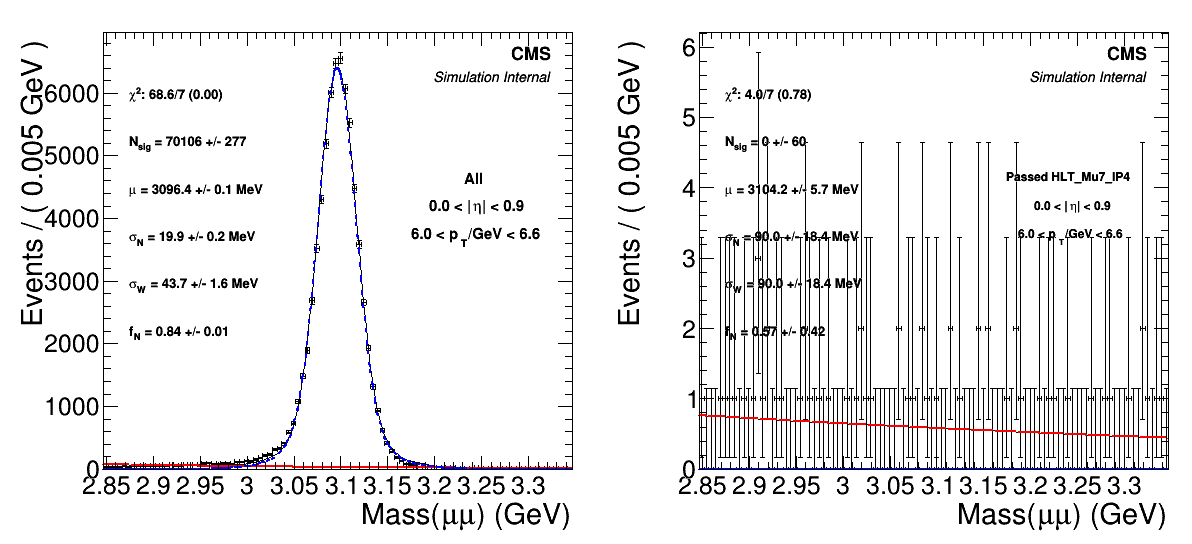

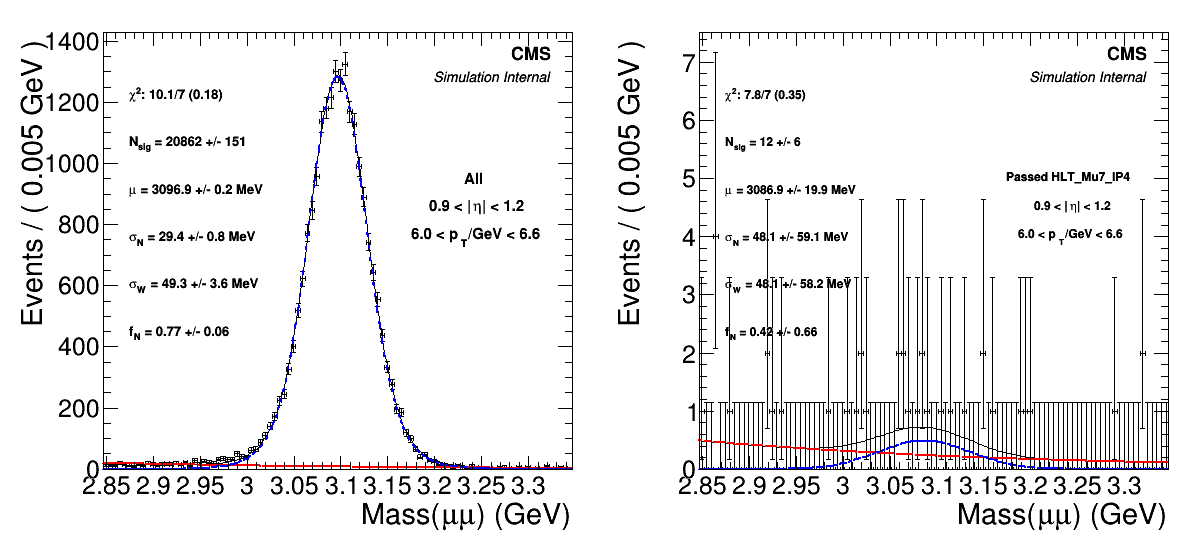

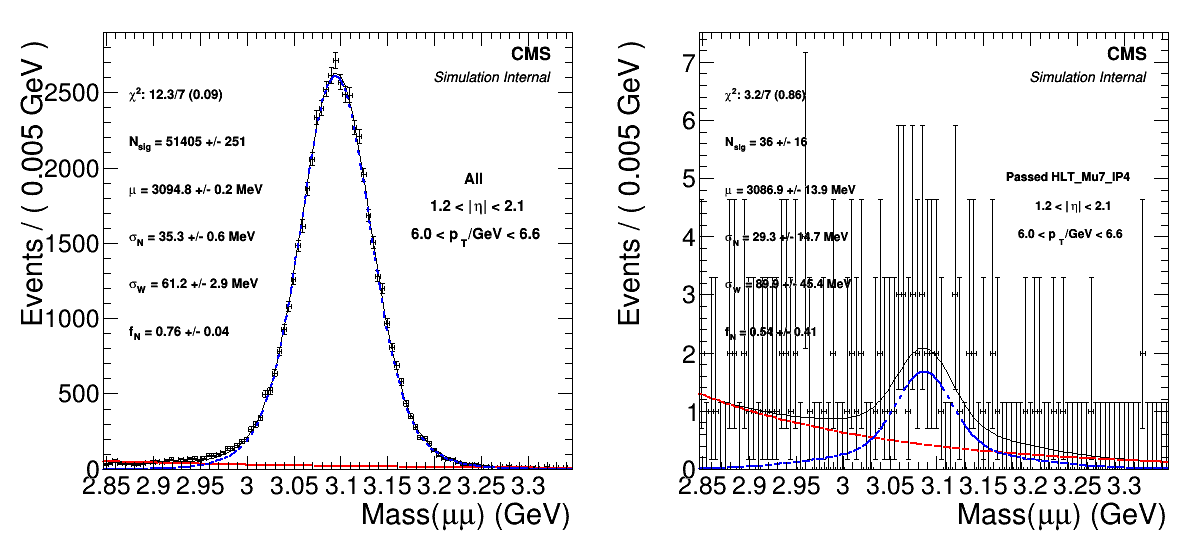

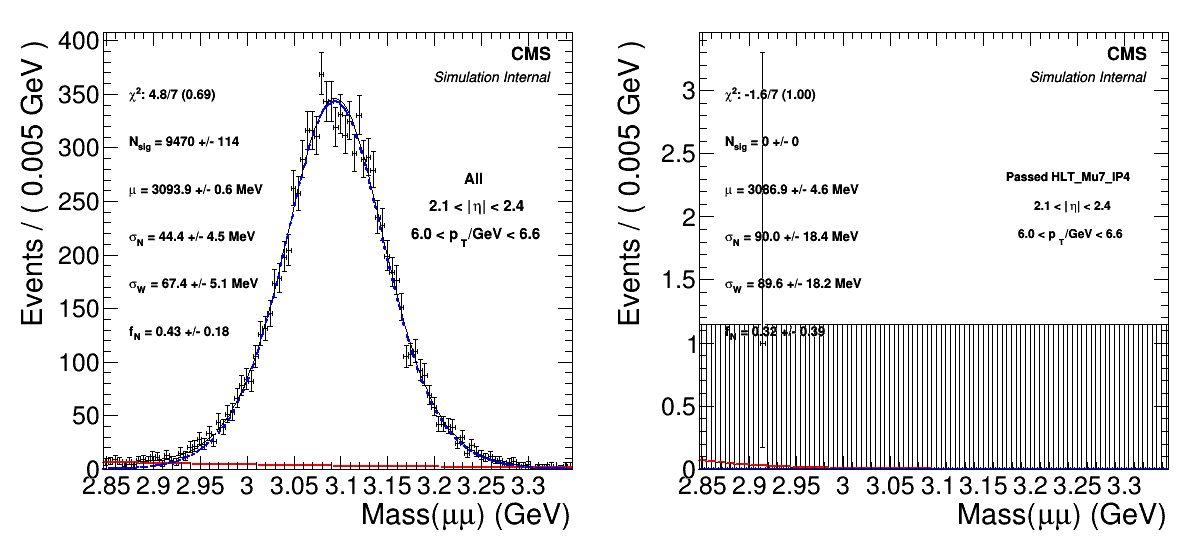

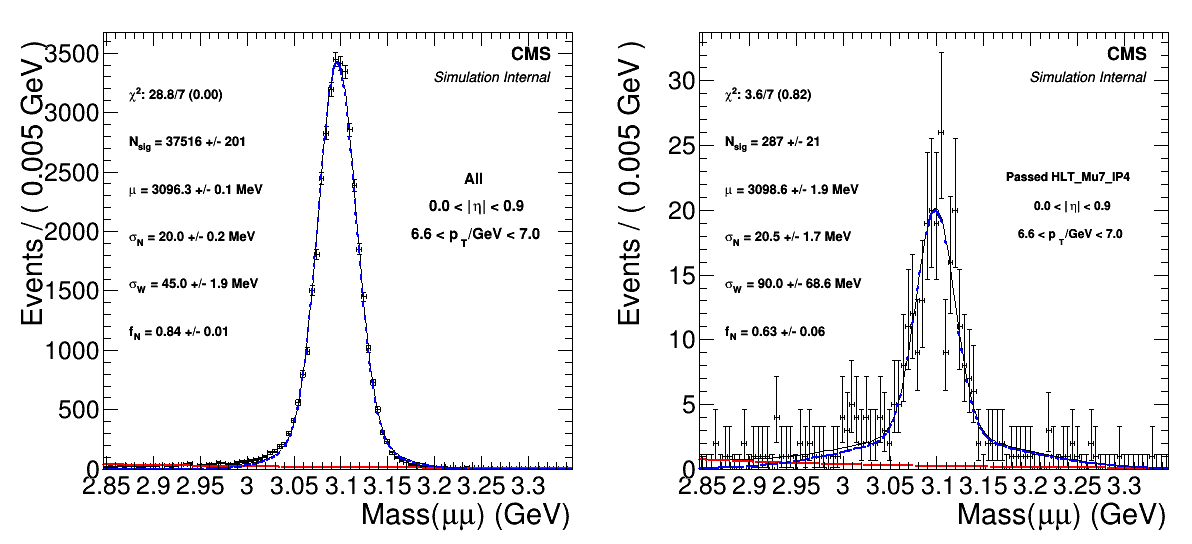

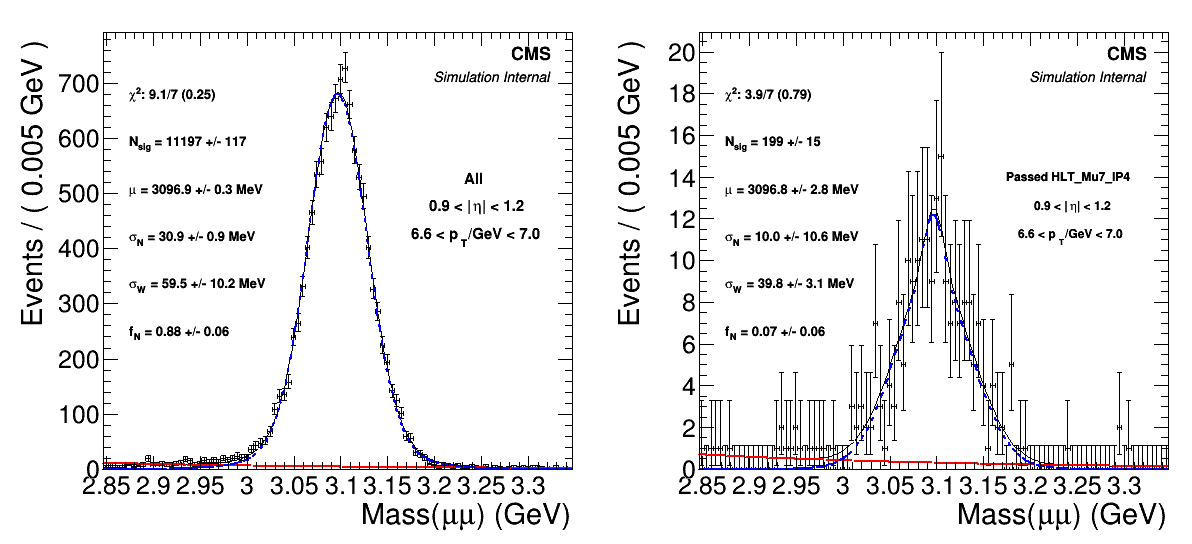

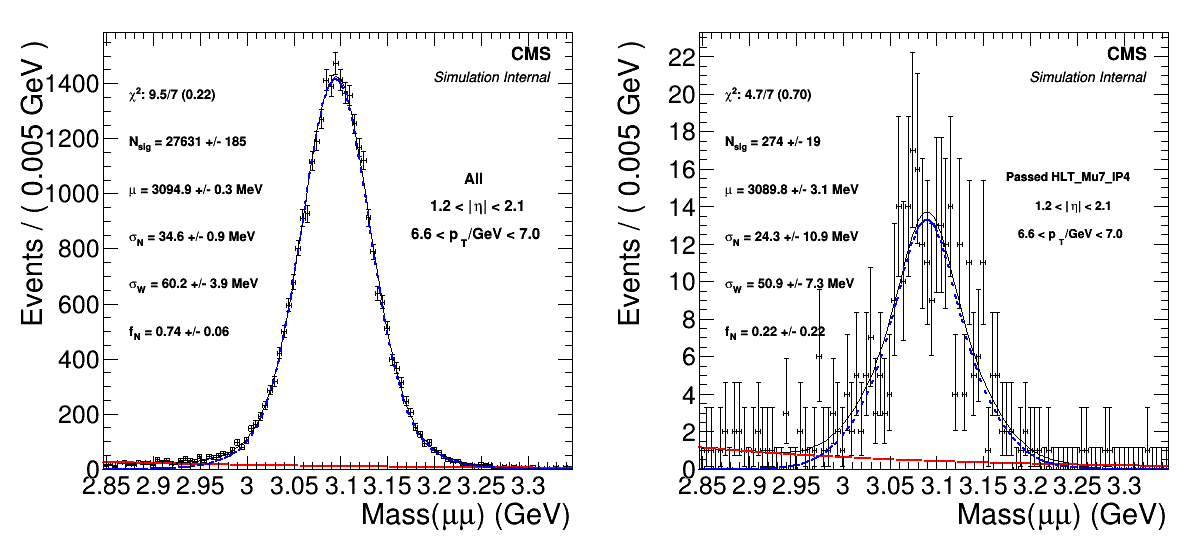

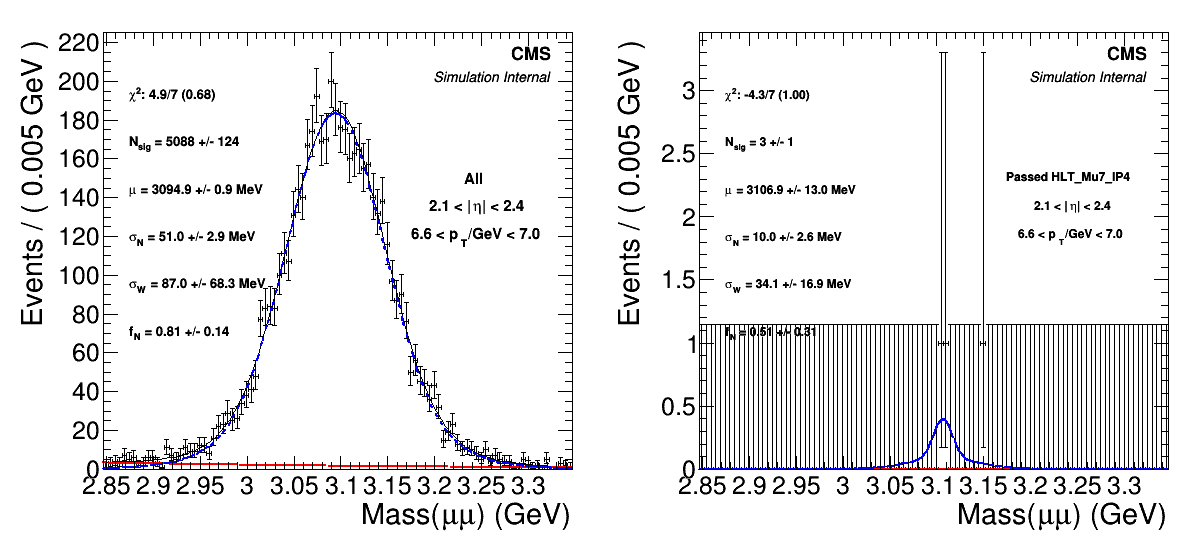

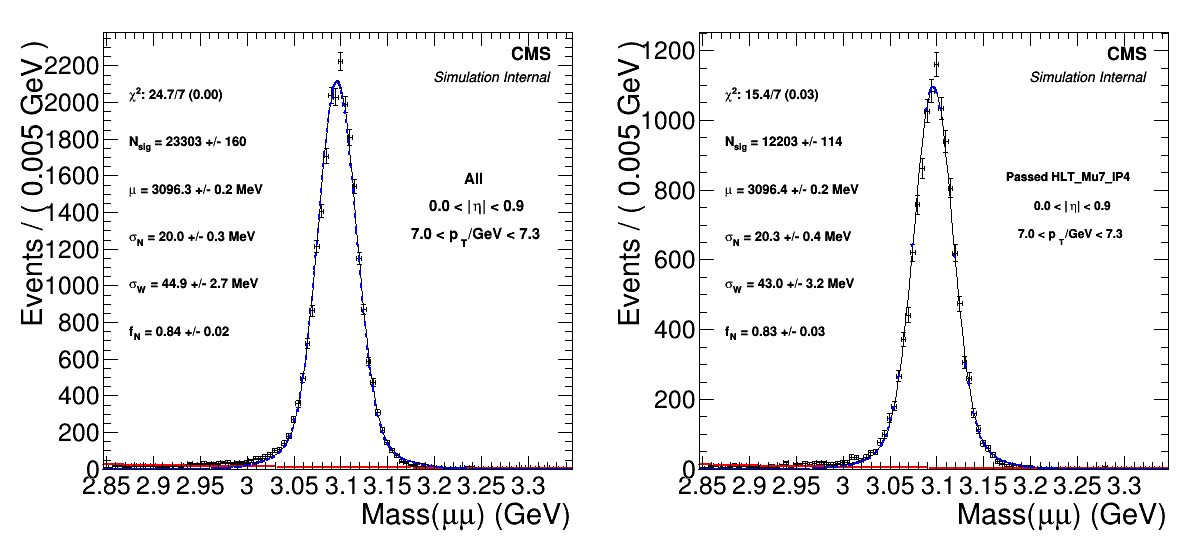

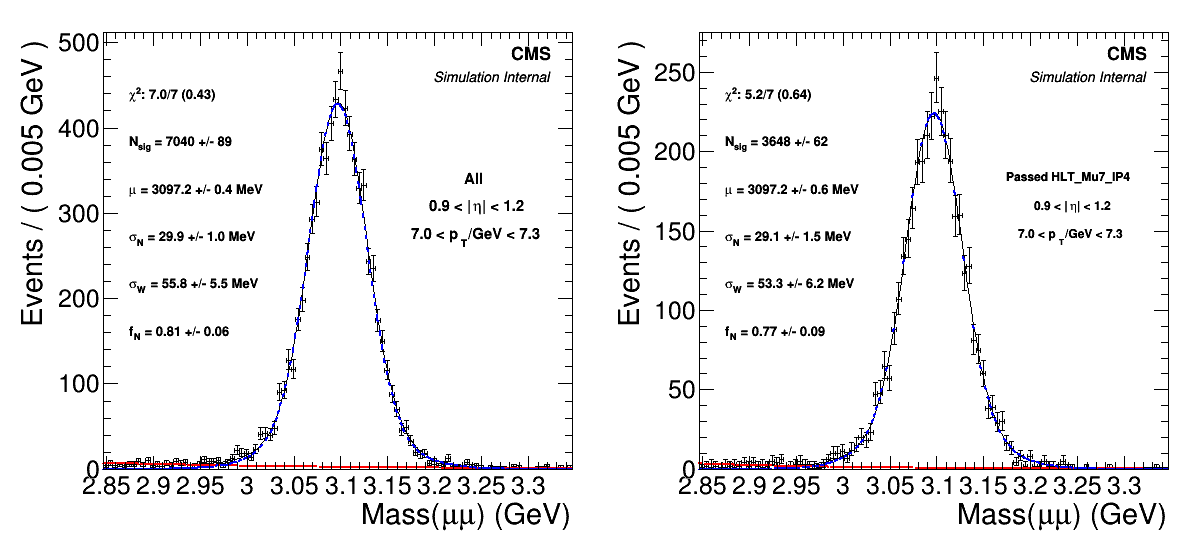

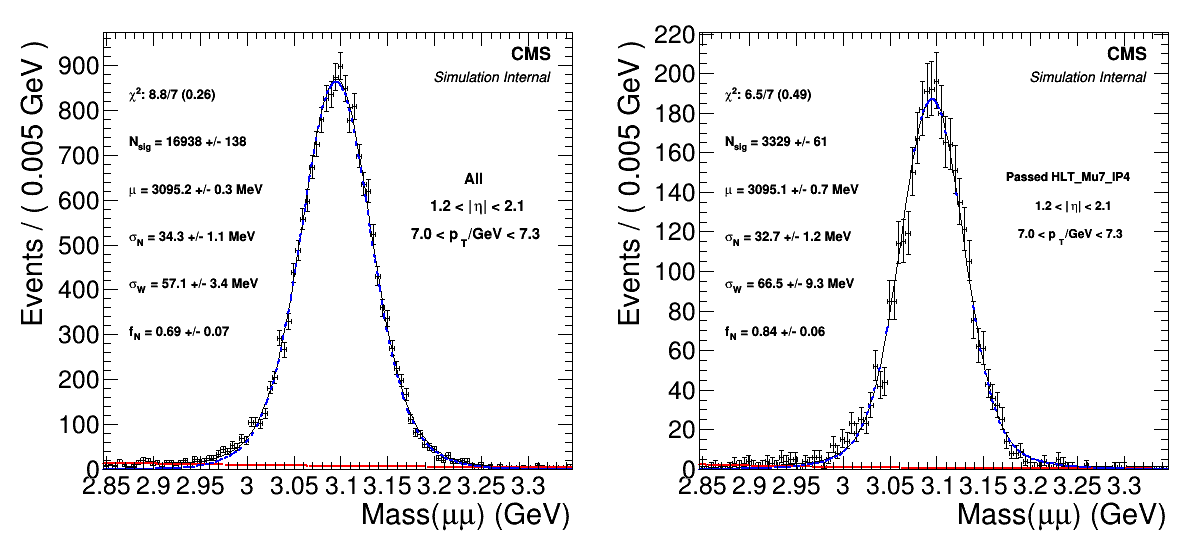

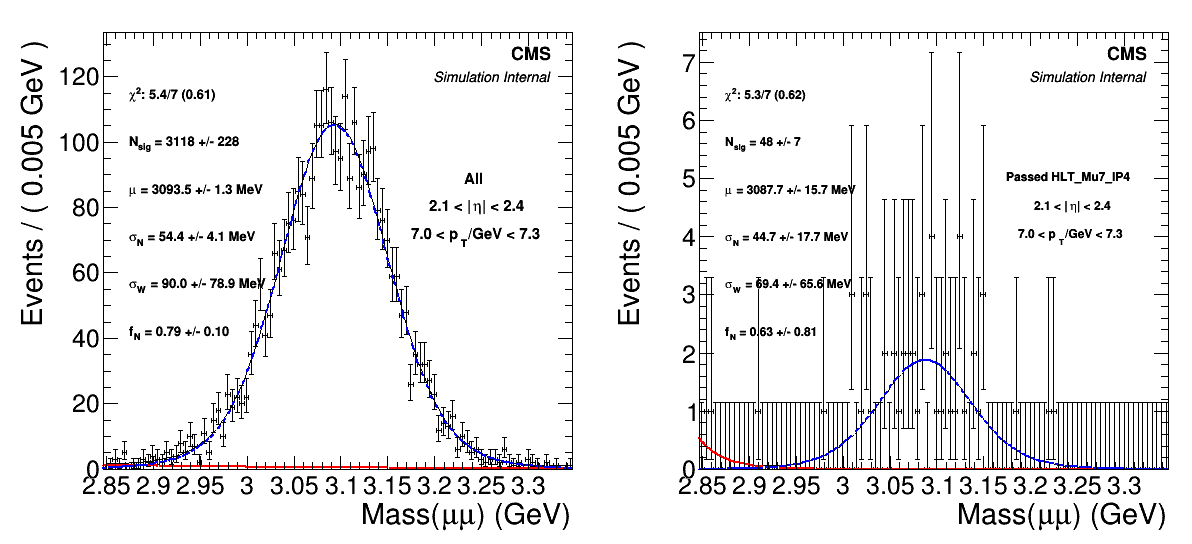

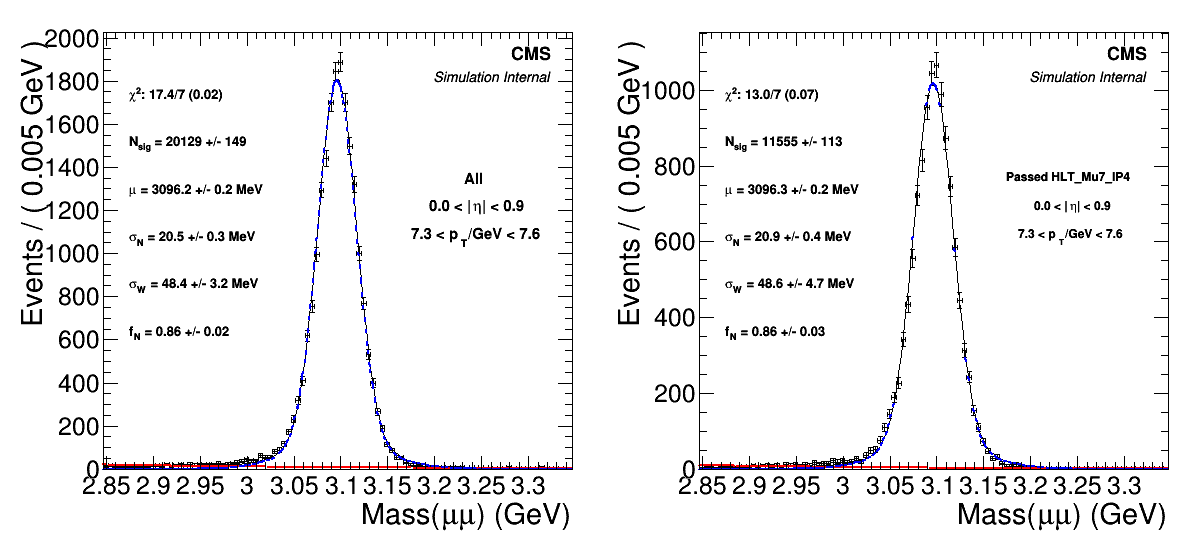

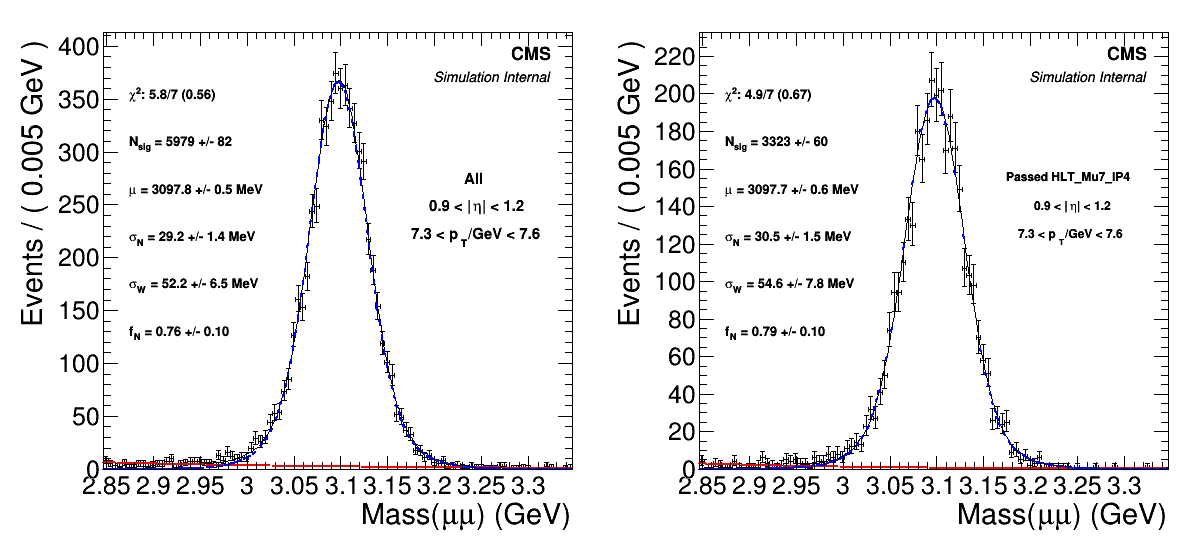

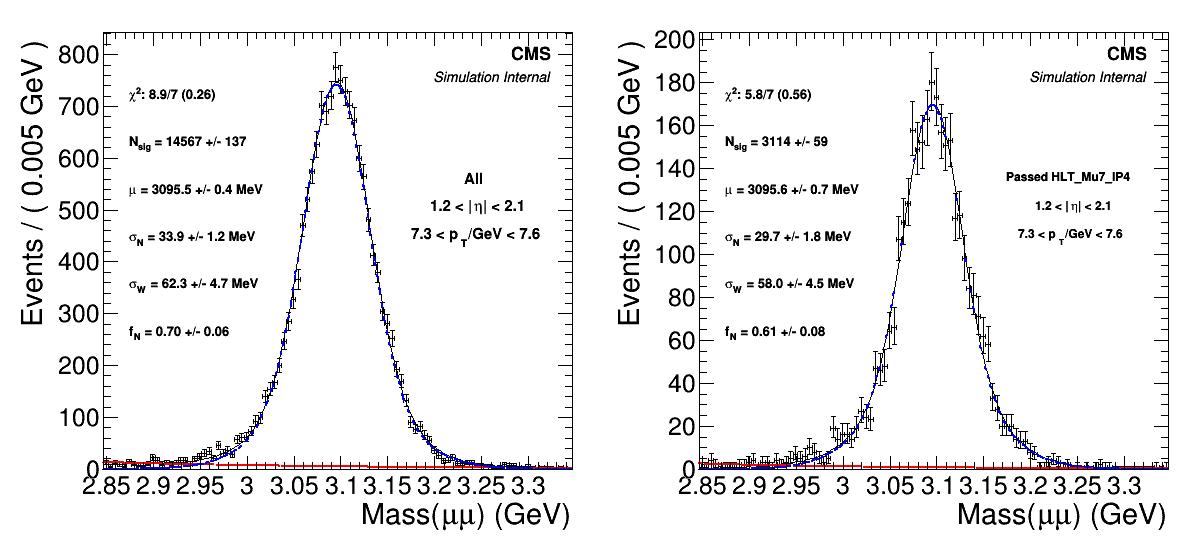

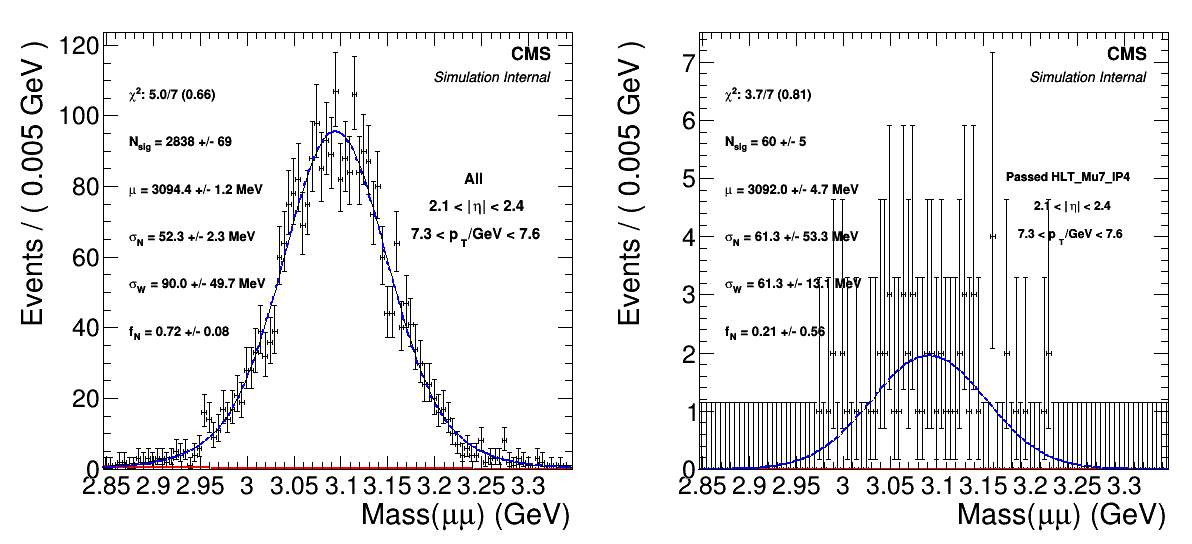

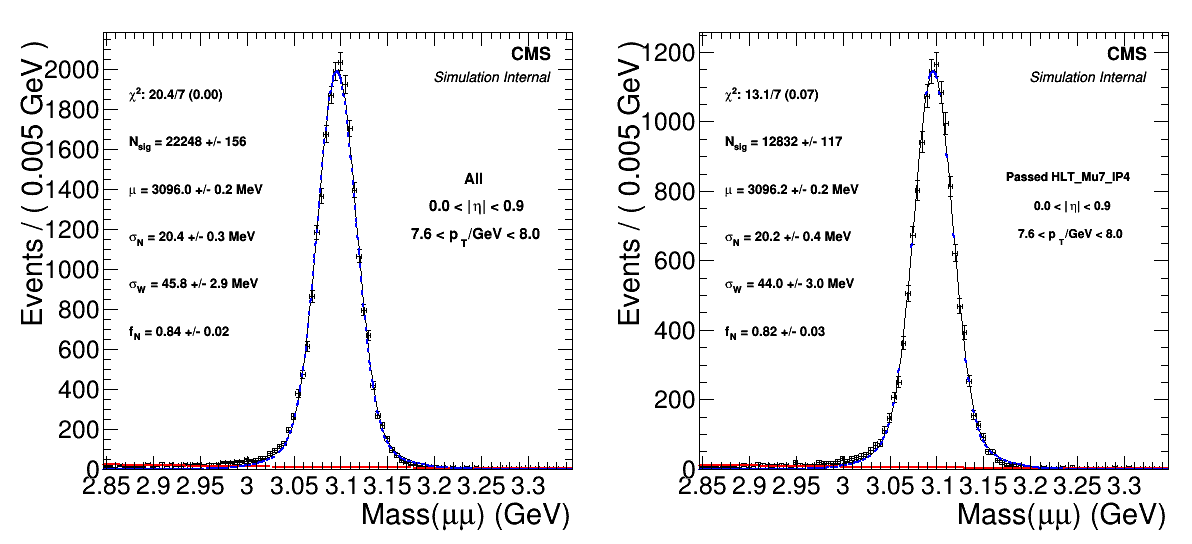

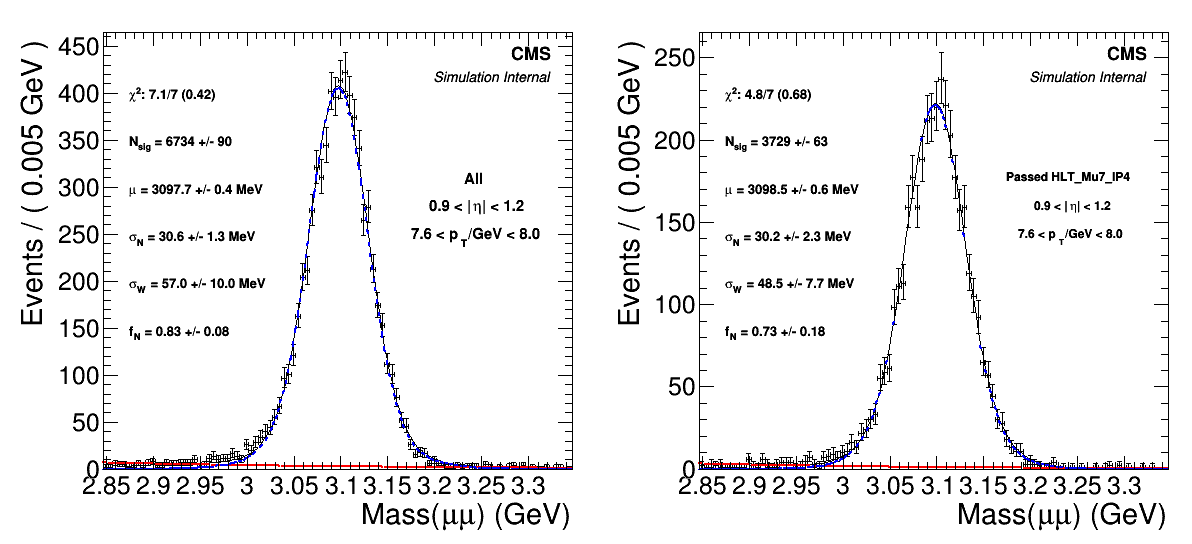

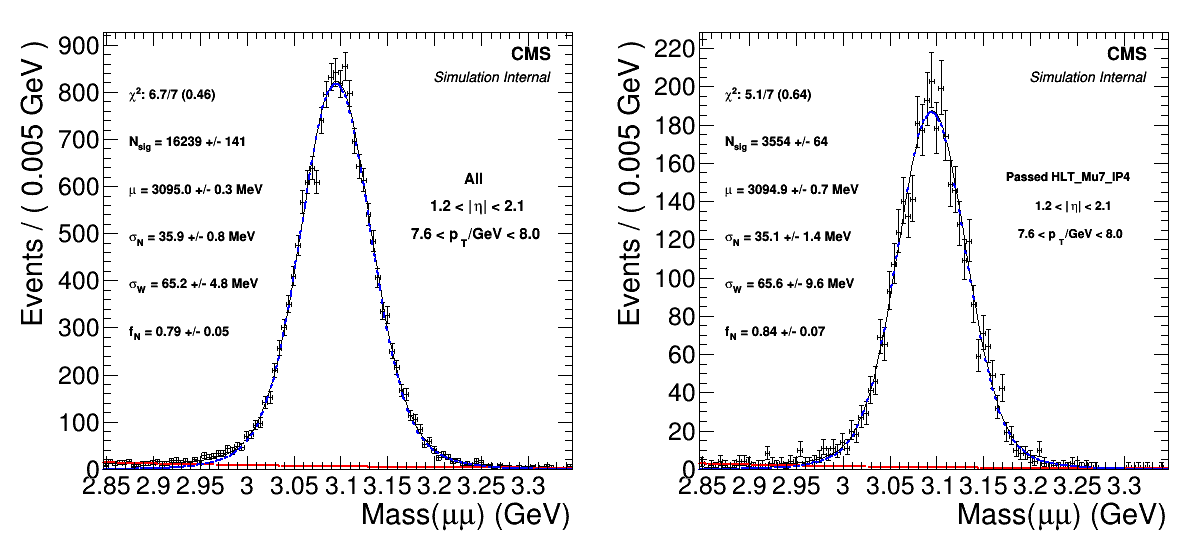

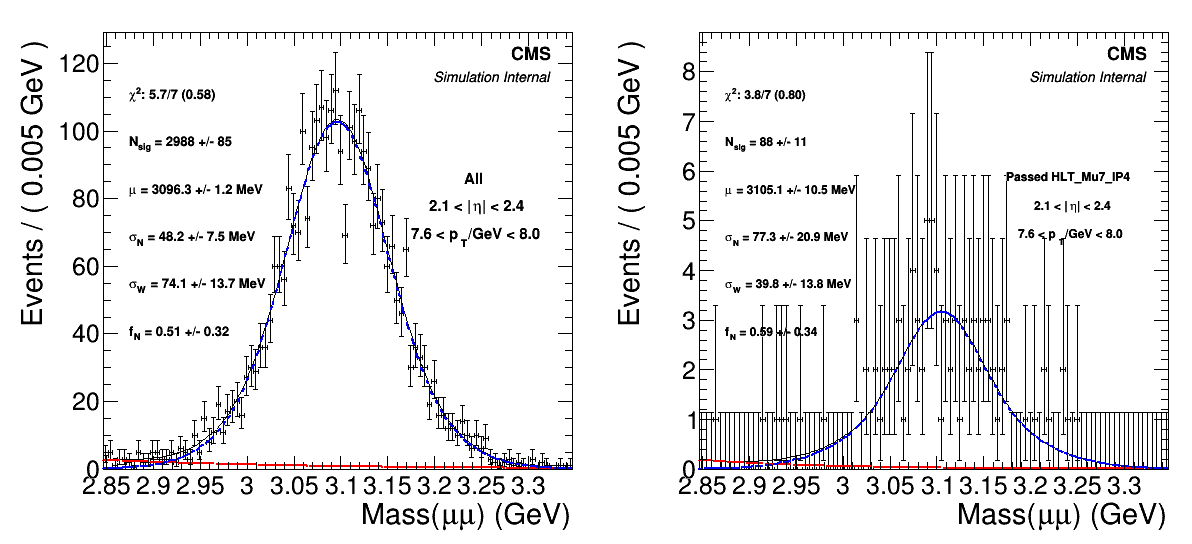

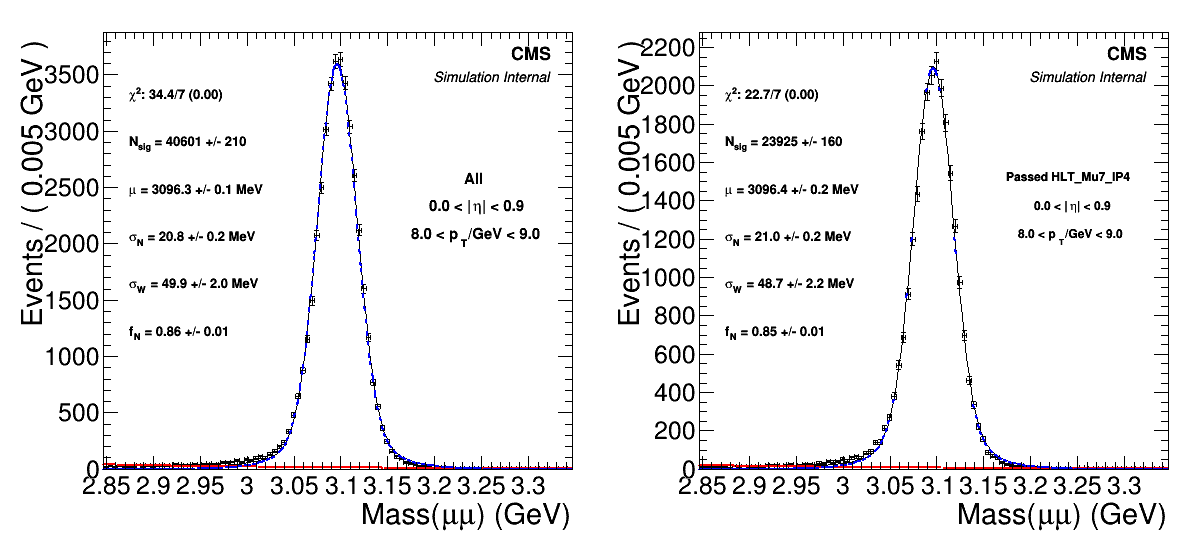

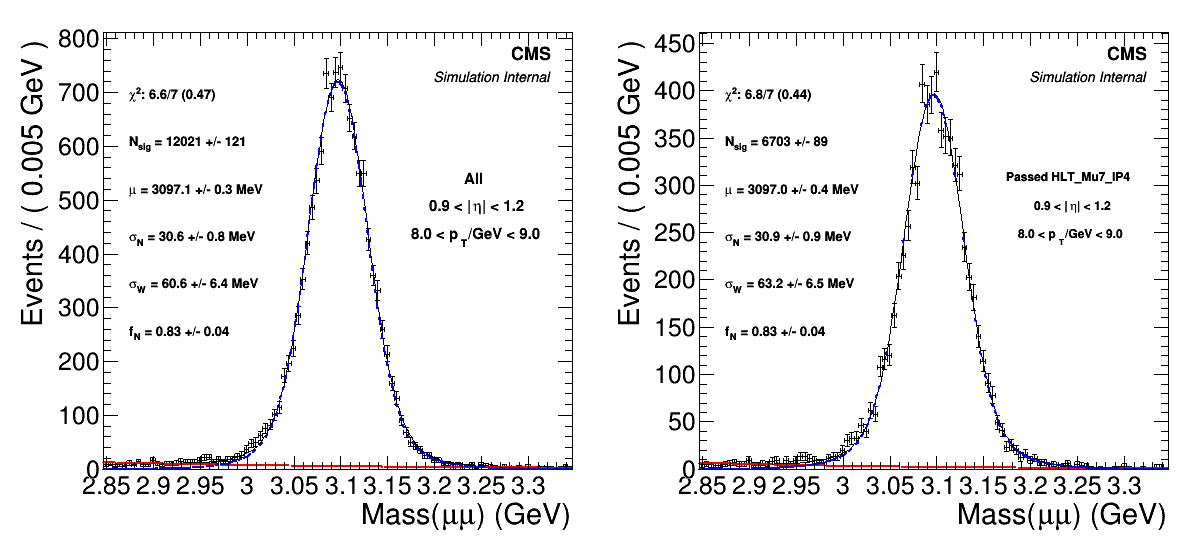

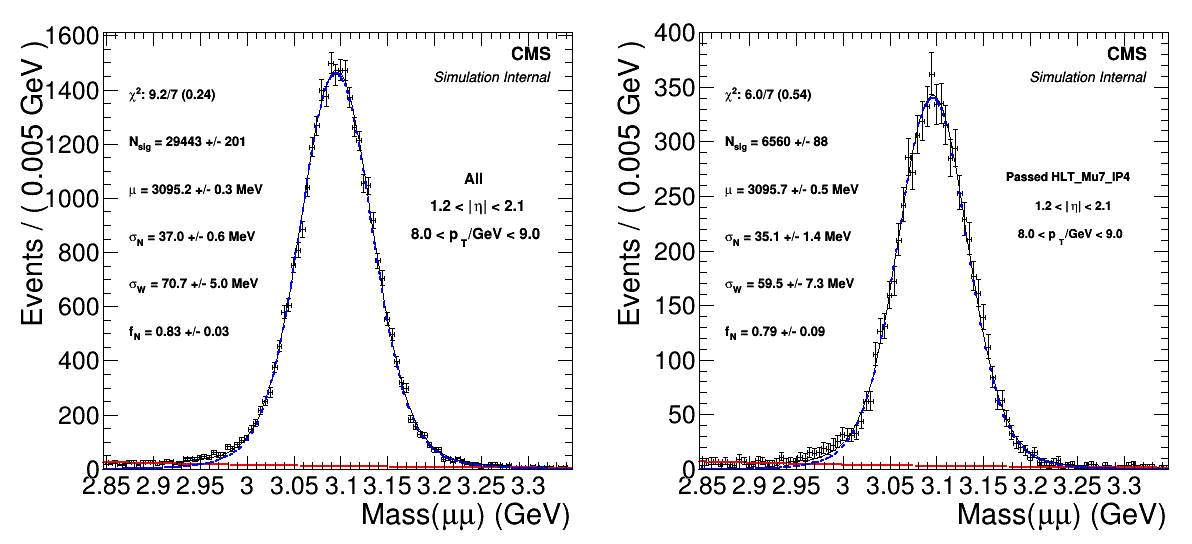

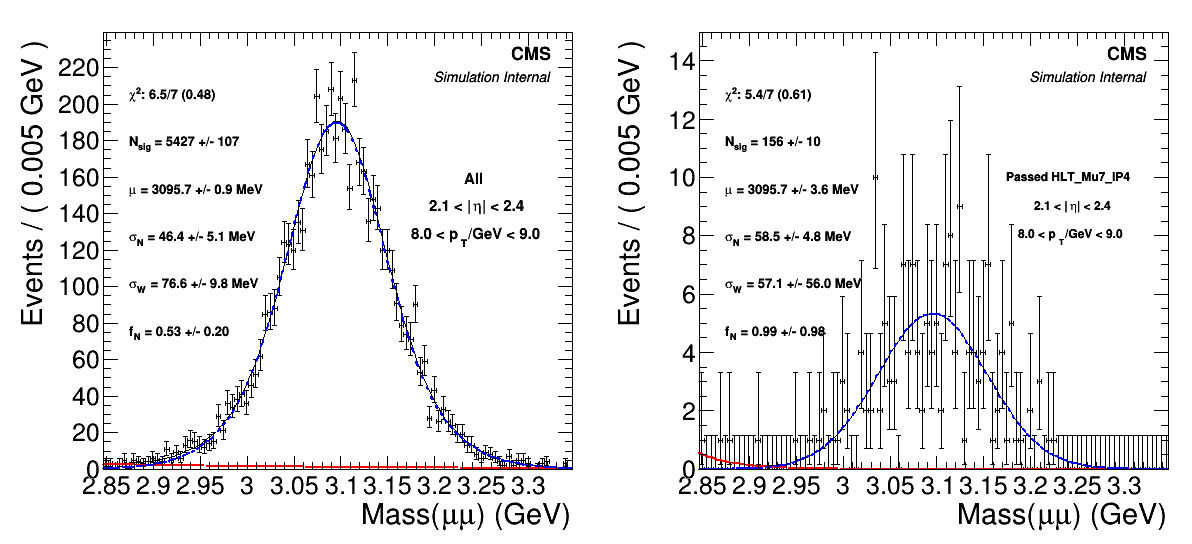

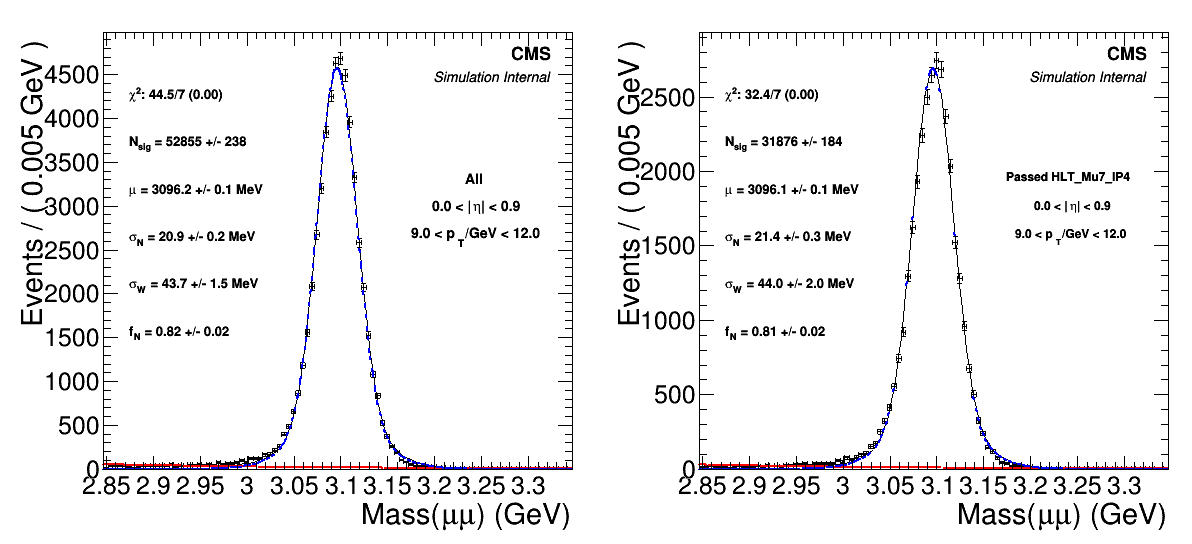

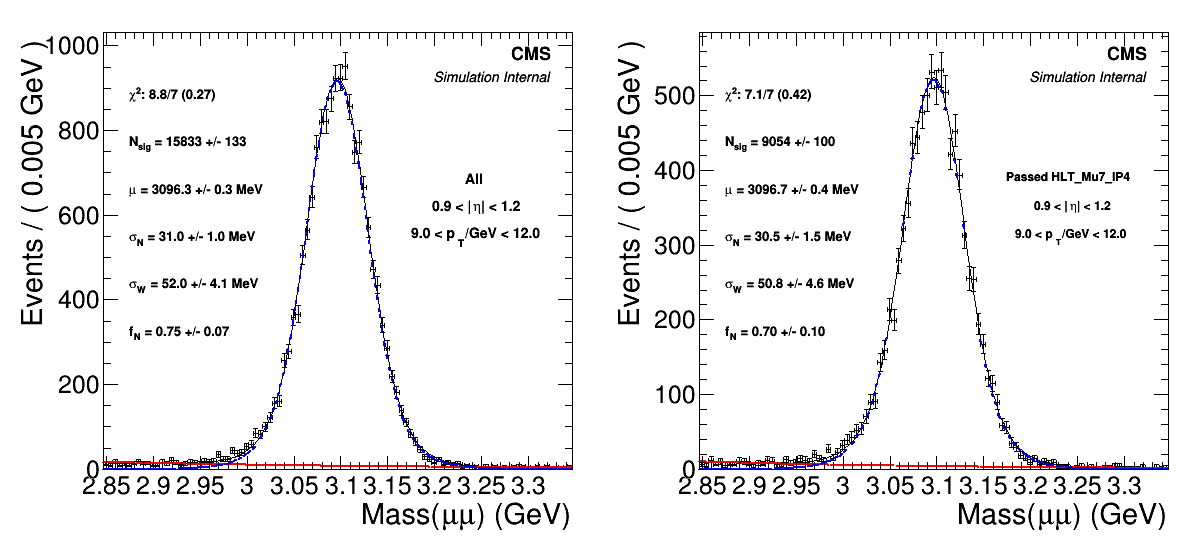

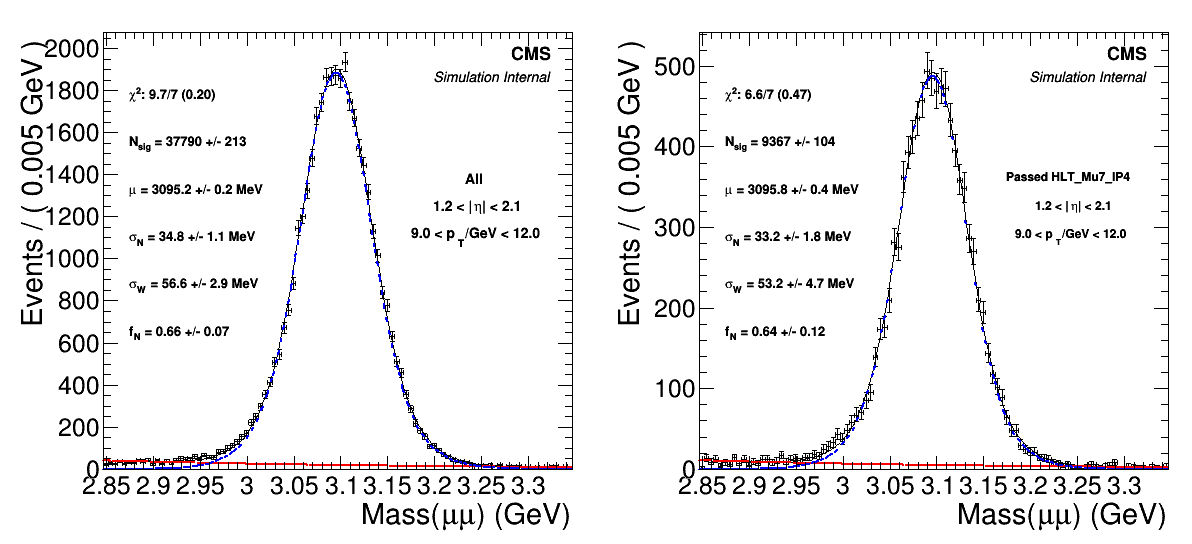

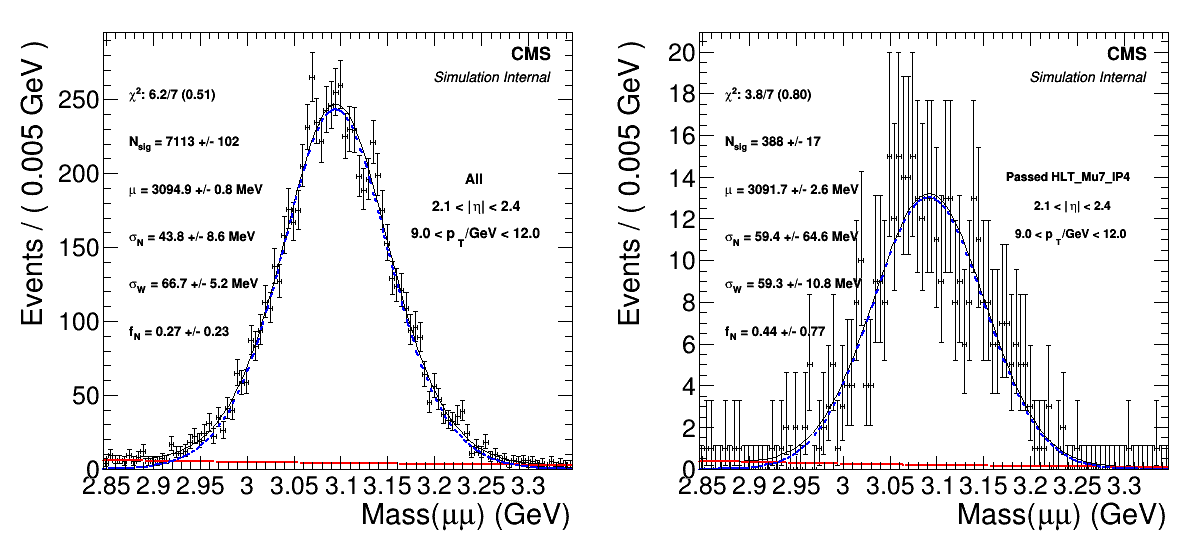

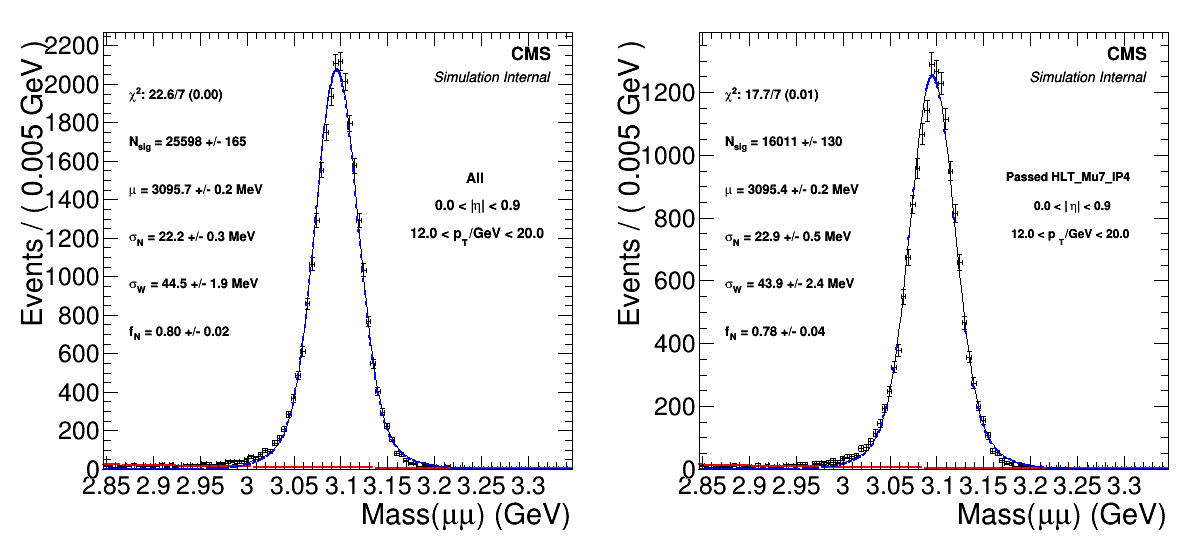

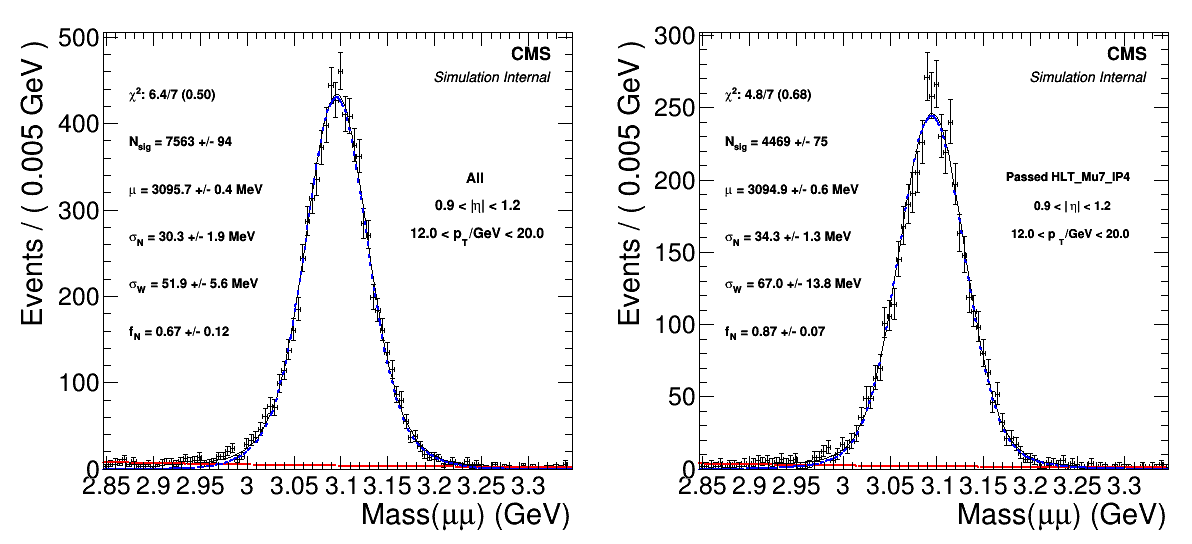

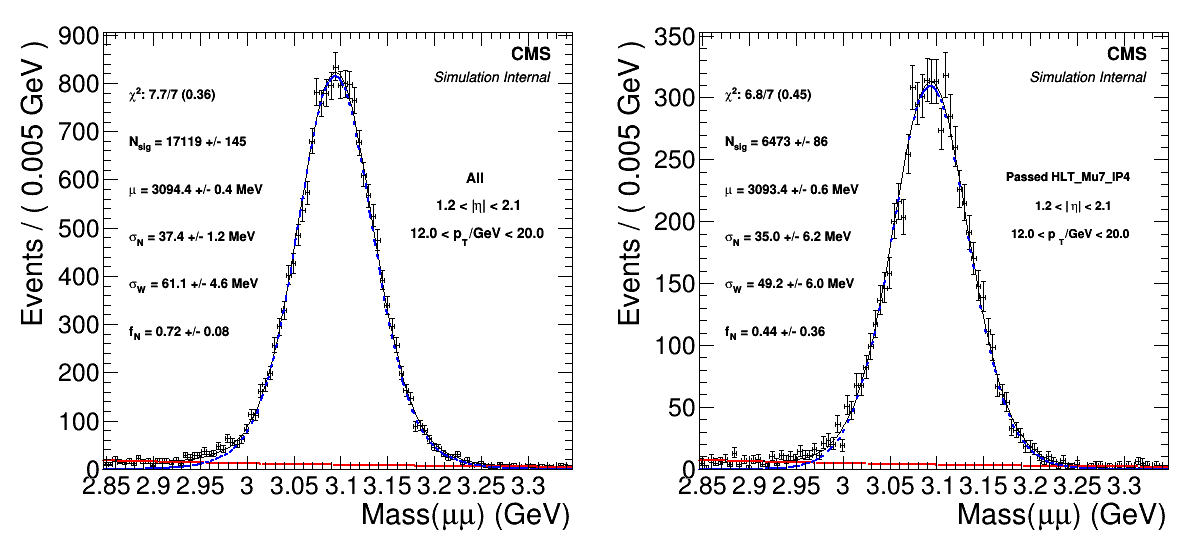

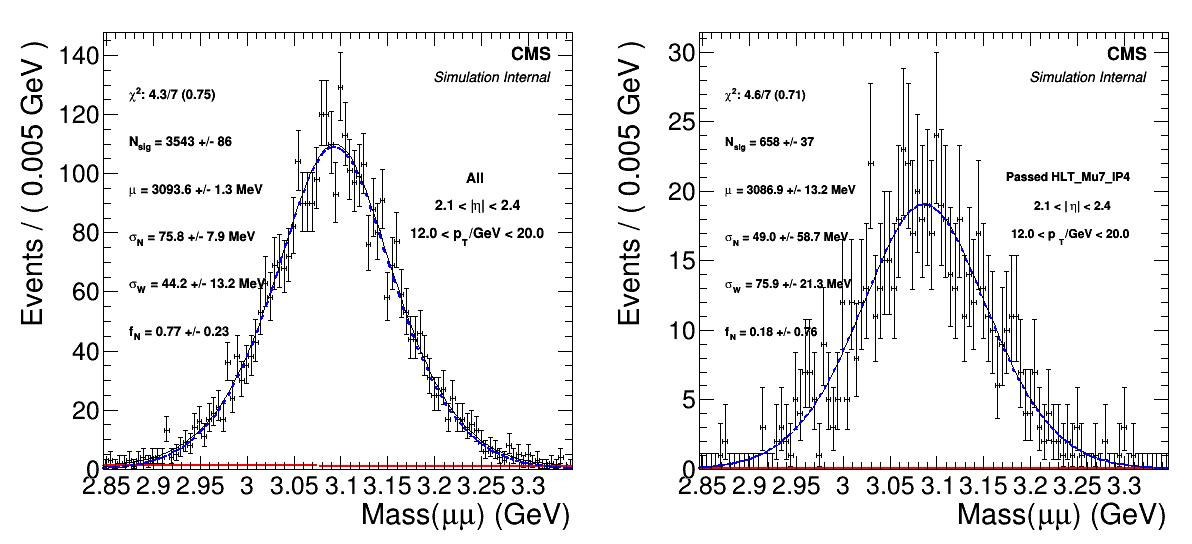

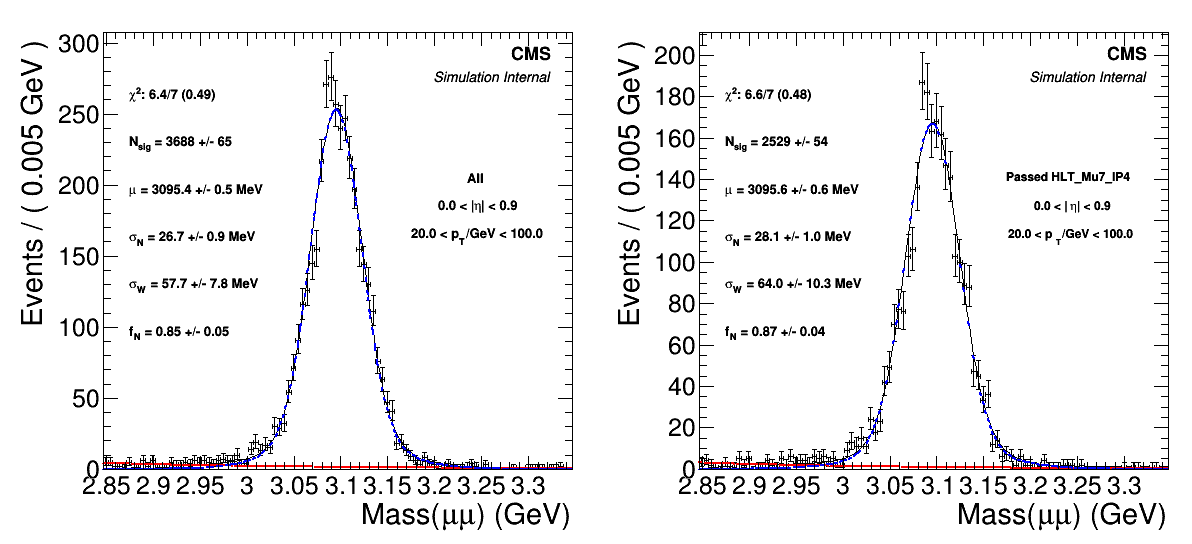

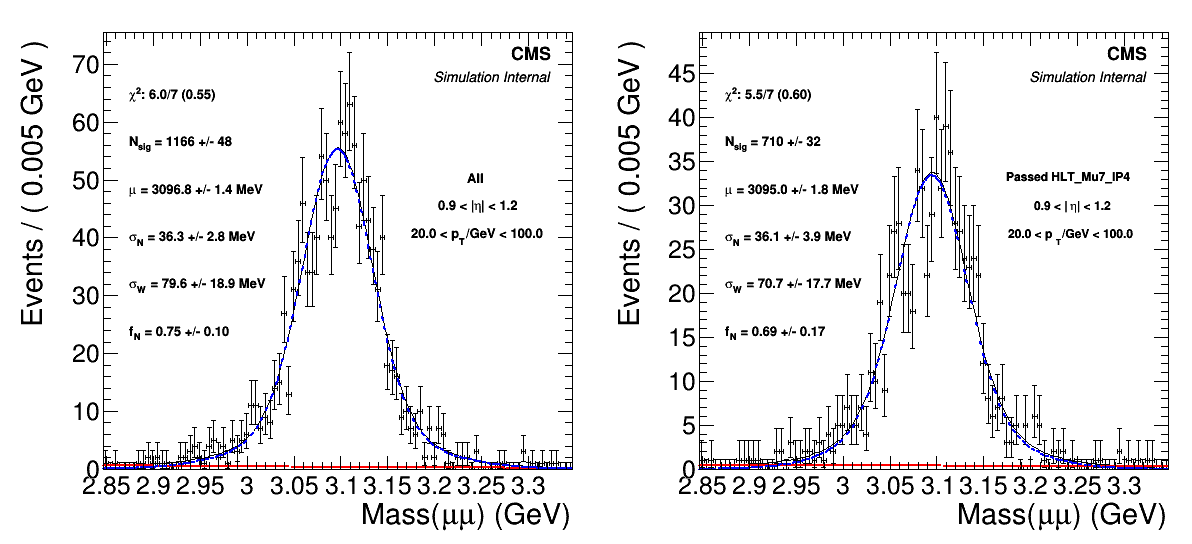

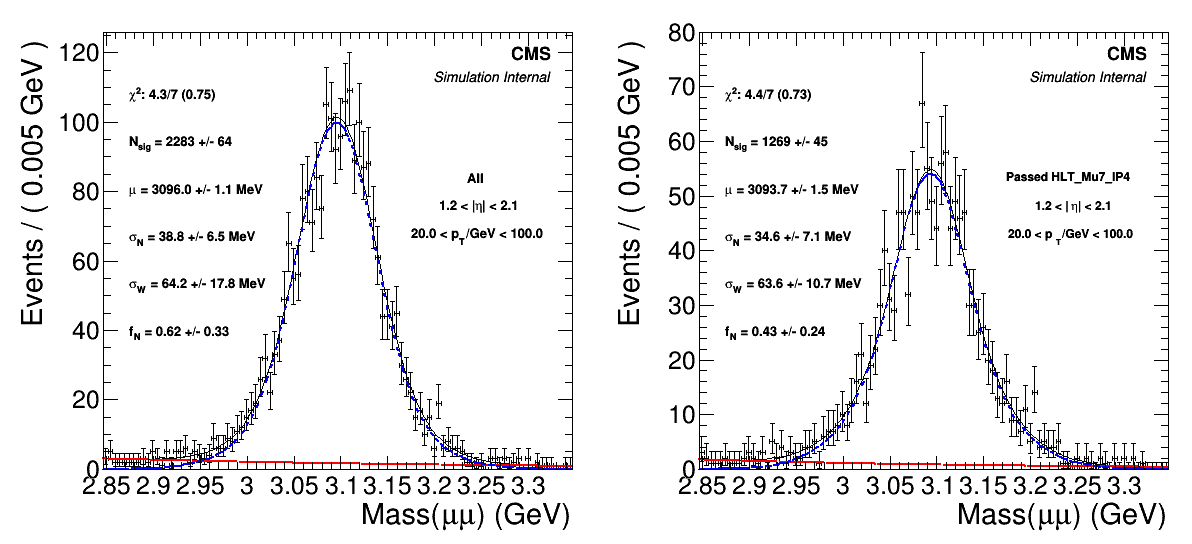

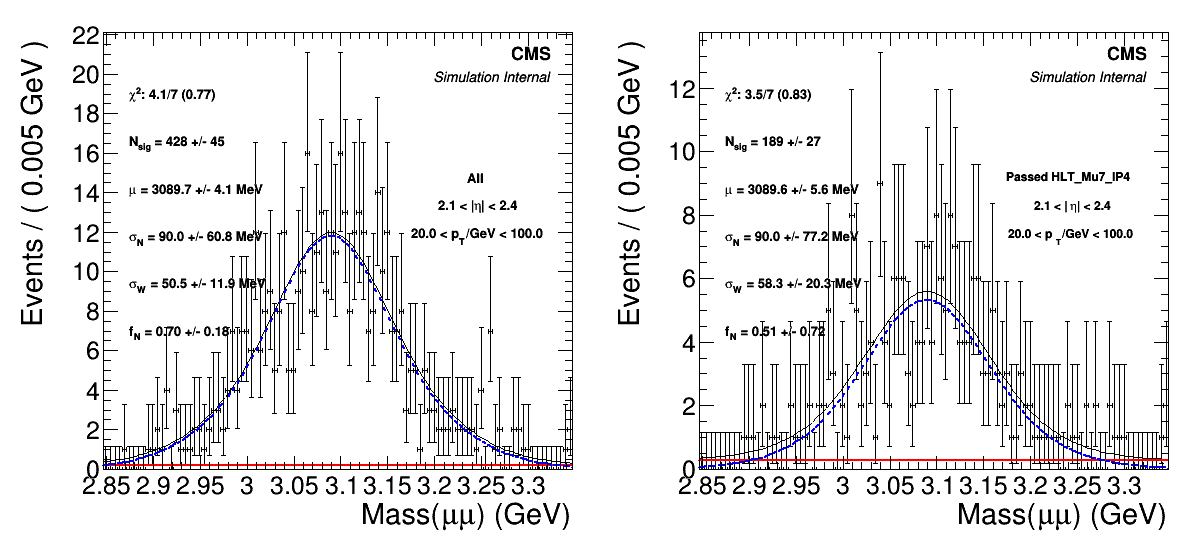

In [19]:
for c, idx, nSigTot, pValTot, nSigPass, pValPass in output:
    c.Draw()

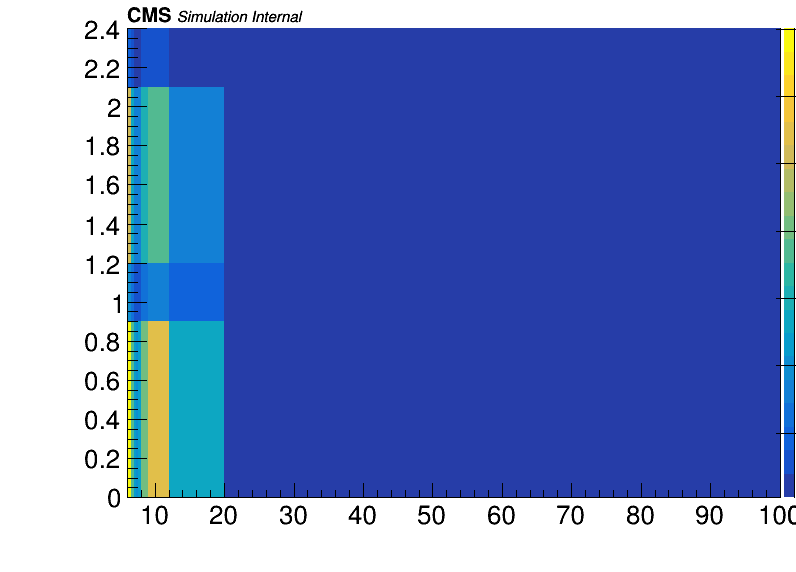

In [18]:
c = drawOnCMSCanvas(CMS_lumi, [hNtot], ['colz'])